In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib as plt
%matplotlib inline
import numpy as np

In [22]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 50

In [23]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/potato-disease/potato",  
    shuffle=True,                   
    image_size=IMAGE_SIZE,           
    batch_size=BATCH_SIZE           
)

Found 2152 files belonging to 3 classes.


In [24]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [25]:
len(dataset)

135

(16, 256, 256, 3)
[1 0 1 0 0 2 1 0 1 0 0 0 1 1 1 1]


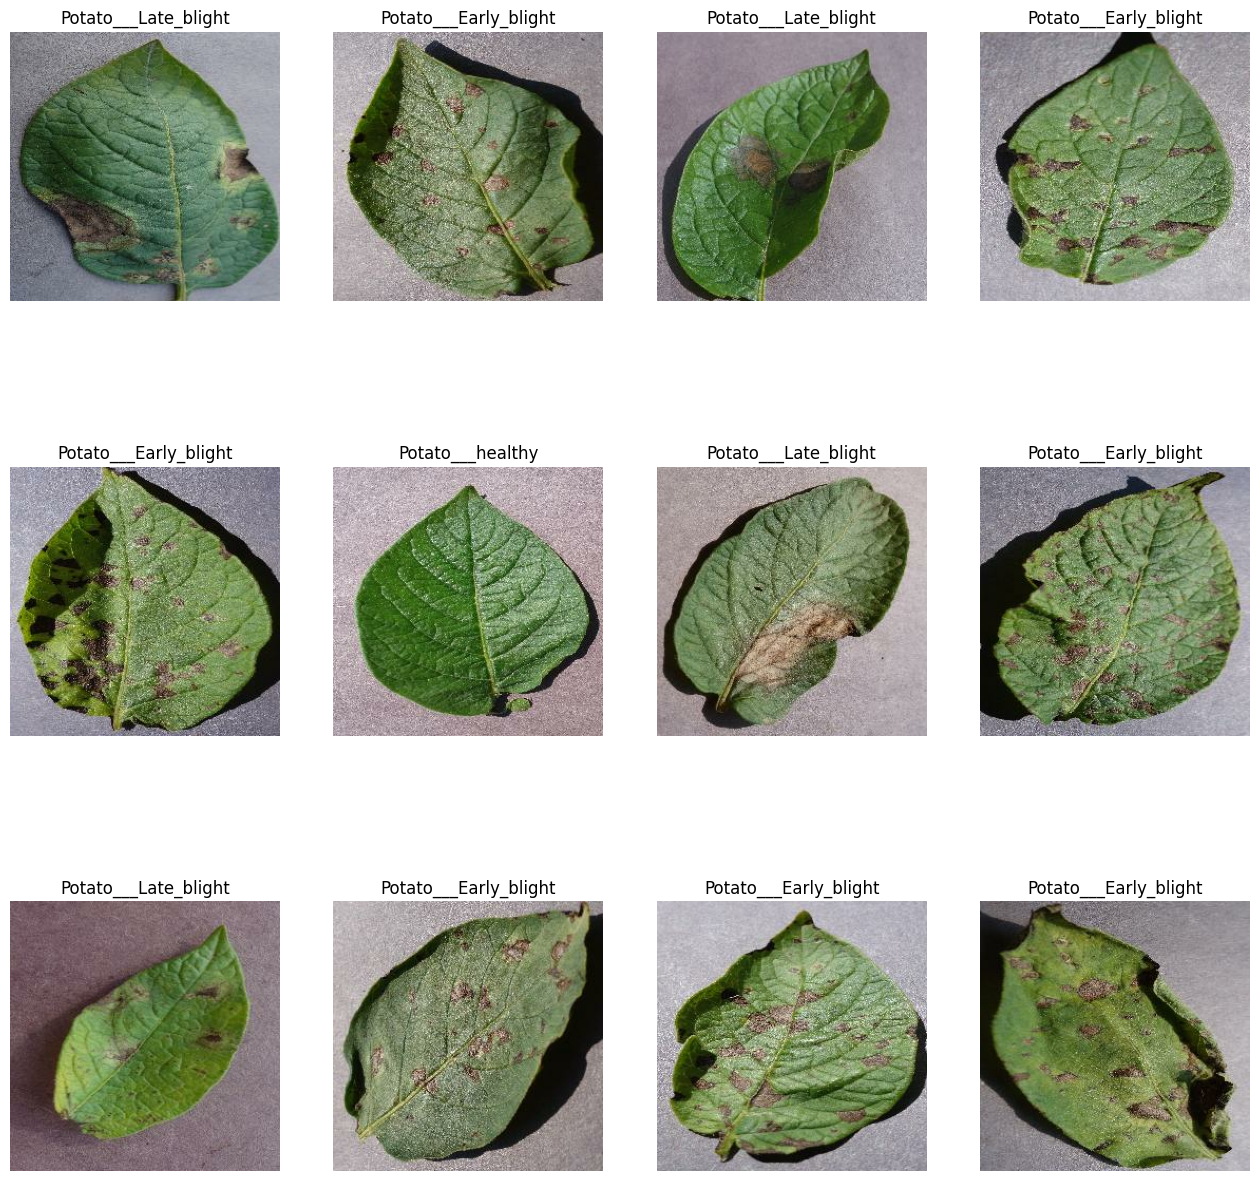

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# spliting

In [27]:
# train_size = 0.8
# len(dataset) * train_size

# trian_ds = dataset.take(516)
# len(trian_ds)

# test_ds = dataset.skip(516)
# len(test_ds)

# val_size = 0.1
# len(dataset) * val_size

# val_ds = test_ds.take(64)
# len(val_ds)

# test_ds = test_ds.skip(64)
# len(test_ds)

In [28]:
dataset_size = len(dataset)

# train_size = int(0.8 * dataset_size)  
# val_size = int(0.1 * dataset_size)    

# train_ds = dataset.take(train_size)               
# test_ds = dataset.skip(train_size)                
# val_ds = test_ds.take(val_size)                    
# test_ds = test_ds.skip(val_size)                   

# print(len(train_ds), len(val_ds), len(test_ds))

In [29]:
def get_dataset_patitions(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)  

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = ds.take(train_size)                  
    test_val_ds = ds.skip(train_size)           

    val_ds = test_val_ds.take(val_size)        
    test_ds = test_val_ds.skip(val_size)          

    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_patitions(dataset)
len(train_ds)

108

In [31]:
len(val_ds)

13

In [32]:
len(test_ds)

14

In [33]:
train_da = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_da = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)  

# rescaling and resizing

In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255),
])

# Applying Augmentation

In [35]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
# ])


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),  
    layers.RandomZoom(0.2),      
    layers.RandomContrast(0.1),  
    layers.RandomTranslation(0.1, 0.1),  
])

In [36]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [37]:
input_shape = (256, 256, 3)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape), 
    resize_and_rescale,  
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )


# history = model.fit(
#     train_ds,
#     batch_size=16,
#     validation_data=val_ds,
#     epochs=50,
#     verbose=1,
# )

In [56]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,  
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=50, 
    verbose=1, 
#     callbacks=[early_stopping], 
    batch_size=32 
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.9643 - loss: 0.1063 - val_accuracy: 0.9519 - val_loss: 0.2177
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.9679 - loss: 0.0935 - val_accuracy: 0.9615 - val_loss: 0.1402
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - accuracy: 0.9601 - loss: 0.1040 - val_accuracy: 0.9500 - val_loss: 0.1121
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 347ms/step - accuracy: 0.9713 - loss: 0.0813 - val_accuracy: 0.9615 - val_loss: 0.1150
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.9707 - loss: 0.0961 - val_accuracy: 0.9808 - val_loss: 0.0425
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.9706 - loss: 0.0751 - val_accuracy: 0.8600 - val_loss: 0.3173
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.9707 - loss: 0.0897 - val_accuracy: 0.9808 - val_loss: 0.0463
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.9833 - loss: 0

In [57]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9938 - loss: 0.0302  


In [58]:
scores

[0.02462186850607395, 0.9955357313156128]

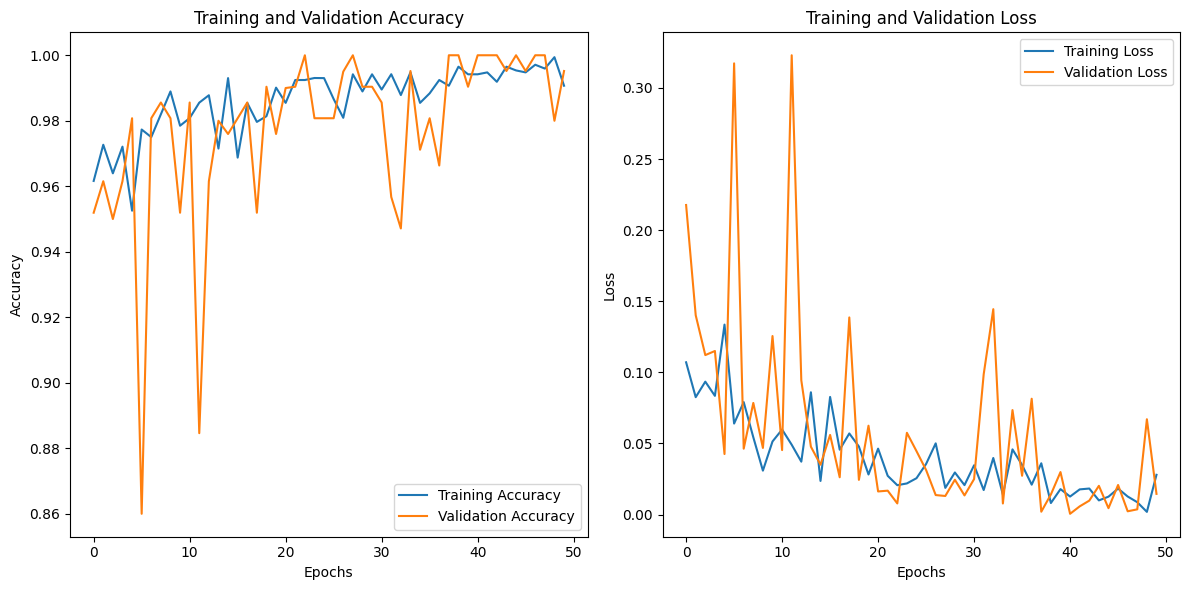

In [59]:
EPOCHS = len(history.history['accuracy'])  

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()  
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
predicted label: Potato___Late_blight


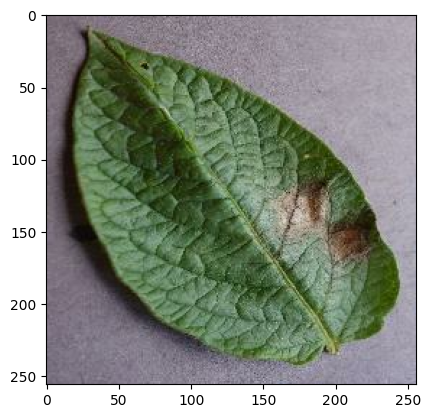

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


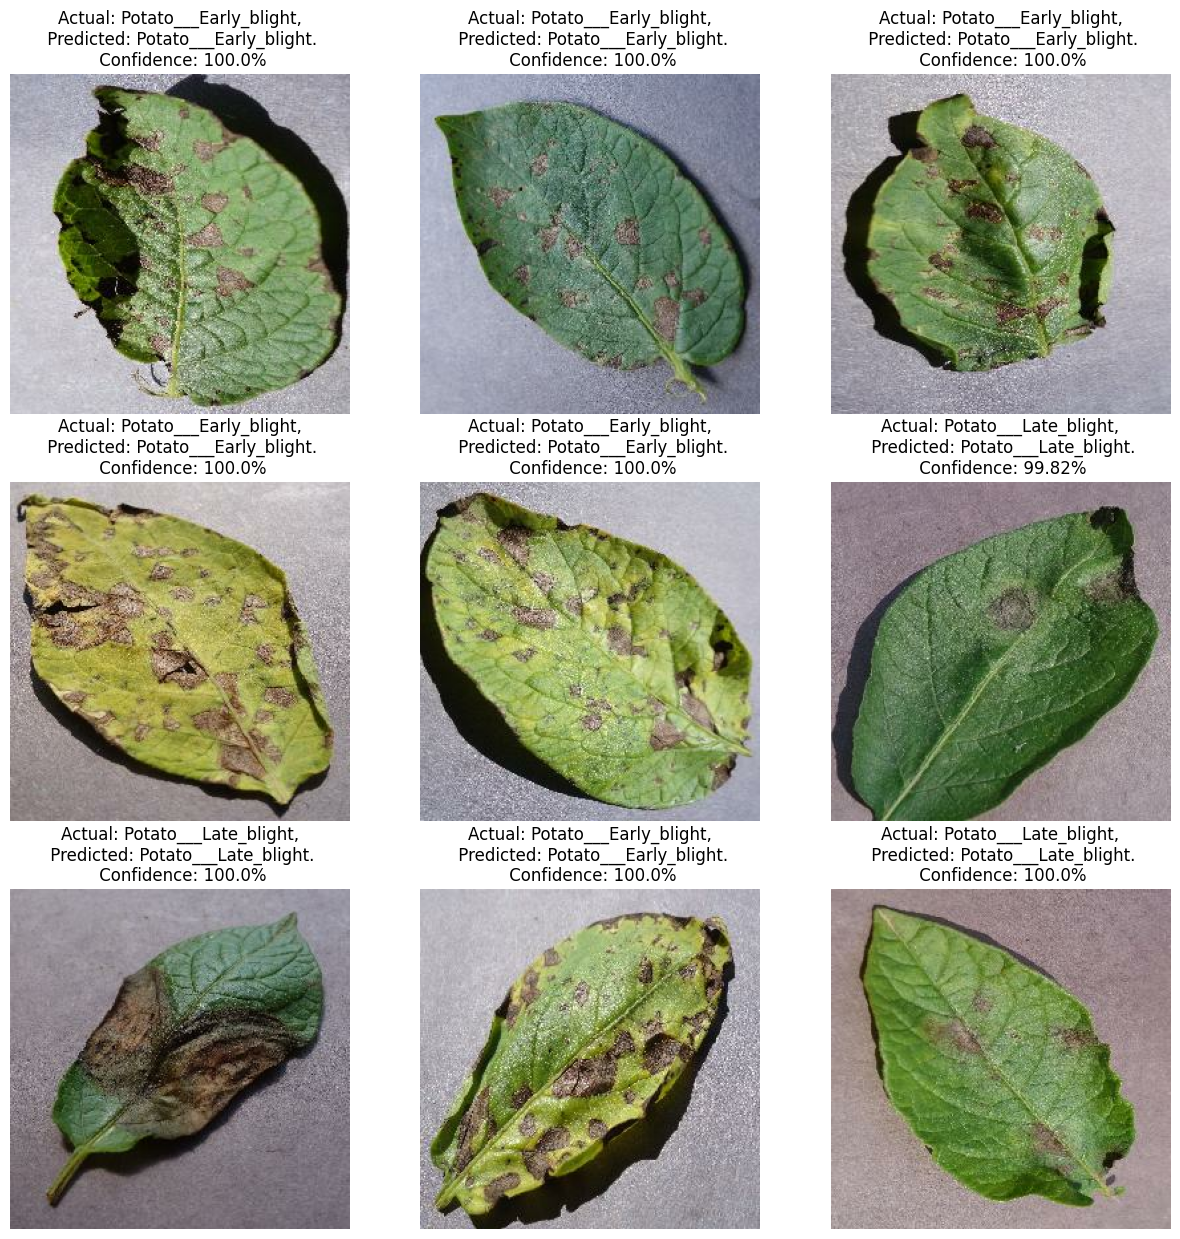

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [72]:
import os
model_dir = "E:/Dataset and models/PlantVillage/potato/model"
os.makedirs(model_dir, exist_ok=True)
print("Contents of model directory before saving:")
print(os.listdir(model_dir))
model_version = max([int(i) for i in os.listdir(model_dir) if i.isdigit()] + [0]) + 1

model.save(os.path.join(model_dir, f"{model_version}.keras"))
print("Contents of model directory after saving:")
print(os.listdir(model_dir))


Contents of model directory before saving:
['1.keras', '1.h5', 'potatoes.h5']
Contents of model directory after saving:
['1.keras', '1.h5', 'potatoes.h5']
